In [1]:
# Import required libraries
from segmentation_pipeline import nnUNet, nnUNetConfidence
from lungmask import LMInferer
from segmentation_pipeline import pydicom_to_nifti
from segmentation_pipeline import apply_windowing
from segmentation_pipeline import random_pad_3d_box
import torch
import torch.nn.functional as F
import cc3d
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pydicom
import os
from pathlib import Path

/afs/csail.mit.edu/u/b/bgrey/DiffusionEvalPipeline/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Helper Functions

In [2]:
def get_dicom_files_with_slice_locations(directory_path):
    """
    Loop through all DICOM files in a directory and extract their paths and slice locations.
    
    Args:
        directory_path (str): Path to the directory containing DICOM files
        
    Returns:
        tuple: (list of file paths, list of corresponding slice locations)
    """
    dicom_paths = []
    slice_locations = []
    
    # Convert to Path object for easier handling
    dir_path = Path(directory_path)
    
    # Check if directory exists
    if not dir_path.exists():
        raise ValueError(f"Directory does not exist: {directory_path}")
    
    # Loop through all files in directory (including subdirectories)
    for file_path in dir_path.rglob('*'):
        # Skip directories
        if file_path.is_dir():
            continue
            
        try:
            # Try to read as DICOM file
            dcm = pydicom.dcmread(str(file_path), stop_before_pixels=True)
            
            # Check if SliceLocation exists in metadata
            if hasattr(dcm, 'Slice Location'):
                dicom_paths.append(str(file_path))
                slice_locations.append(float(dcm['Slice Location'].value))
            elif hasattr(dcm, 'ImagePositionPatient'):
                # Alternative: use Z coordinate from ImagePositionPatient if SliceLocation not available
                dicom_paths.append(str(file_path))
                slice_locations.append(float(dcm.ImagePositionPatient[2]))
        except Exception as e:
            # Skip files that are not valid DICOM files
            continue
    
    return dicom_paths, slice_locations

In [3]:
def order_slices(img_paths, slice_locations, reverse=False):
    sorted_ids = np.argsort(slice_locations)
    if reverse:
        sorted_ids = sorted_ids[::-1]
    sorted_img_paths = np.array(img_paths)[sorted_ids].tolist()
    sorted_slice_locs = np.sort(slice_locations).tolist()

    return sorted_img_paths, sorted_slice_locs

## Load Models

In [4]:
# Load segmentation model checkpoint
segmentation_model_checkpoint = torch.load(
    "/data/rbg/scratch/lung_ct/checkpoints/5678b14bb8a563a32f448d19a7d12e6b/last.ckpt",
    weights_only=False
)

new_segmentation_model_state_dict = {}
for k, v in segmentation_model_checkpoint["state_dict"].items():
    if "classifier" not in k:
        new_k = k.replace("model.model", "model")  
        new_segmentation_model_state_dict[new_k] = v

In [5]:
# Load confidence model checkpoint
confidence_model_checkpoint = torch.load(
    "/data/rbg/scratch/lung_ct/checkpoints/4296b4b6cda063e96d52aabfb0694a04/4296b4b6cda063e96d52aabfb0694a04epoch=9.ckpt",
    weights_only=False
)

new_confidence_model_state_dict = {}
for k, v in confidence_model_checkpoint["state_dict"].items():
    new_k = k.replace("model.model", "model")  
    if "model.classifier" in new_k:
        new_k = new_k.replace("model.classifier", "classifier")
    new_confidence_model_state_dict[new_k] = v

In [6]:
# Initialize models
segmentation_model = nnUNet(
    segmentation_model_checkpoint["hyper_parameters"]["args"]
)
segmentation_model.load_state_dict(new_segmentation_model_state_dict)

confidence_model = nnUNetConfidence(
    confidence_model_checkpoint["hyper_parameters"]["args"]
)
confidence_model.load_state_dict(new_confidence_model_state_dict)

# Load lungmask model
model = LMInferer(
    modelpath="/data/rbg/users/pgmikhael/current/lungmask/checkpoints/unet_r231-d5d2fc3d.pth",
    tqdm_disable=True,
    batch_size=100,
    force_cpu=False,
)

# Set to eval mode
segmentation_model.eval()
confidence_model.eval()

nnUNetConfidence(
  (model): ResidualEncoder(
    (stem): StackedConvBlocks(
      (convs): Sequential(
        (0): ConvDropoutNormReLU(
          (conv): Conv3d(2, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (norm): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (nonlin): LeakyReLU(negative_slope=0.01, inplace=True)
          (all_modules): Sequential(
            (0): Conv3d(2, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
            (2): LeakyReLU(negative_slope=0.01, inplace=True)
          )
        )
      )
    )
    (stages): Sequential(
      (0): StackedResidualBlocks(
        (blocks): Sequential(
          (0): BasicBlockD(
            (conv1): ConvDropoutNormReLU(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
              (norm

## Load Image Data

In [7]:
# # Option 1: Load from DICOM directory (commented out)
# dicom_dir = "/data/rbg/shared/datasets/NLST/NLST/all_nlst-ct/set2/batch1/102676/T0/1.2.840.113654.2.55.106468547949258489874106374248199128625/"
# img_paths, slice_locations = get_dicom_files_with_slice_locations(dicom_dir)
# sorted_img_paths, sorted_slice_locs = order_slices(img_paths, slice_locations, reverse=False)
# depth = len(sorted_img_paths)
# # sorted_img_paths = sorted_img_paths[depth//2 - 10: depth//2 + 10]
# print(f"Number of slices found: {len(sorted_img_paths)}")
# oldimage = pydicom_to_nifti(
#     sorted_img_paths,
#     return_nifti=False, save_nifti=False,
#     output_path="buffer",
# )
# print(f"Original image shape: {oldimage.shape}, dtype: {oldimage.dtype}")
# print(f"Unique values in original image: {np.unique(oldimage)}")

# # Option 2: Load from numpy file
# voxel_spacing = [0.8, 0.8, 1.5]  # y, x, z
# affine = torch.diag(torch.tensor(voxel_spacing + [1]))

# image = np.load("image_array_depth20.npy")
# print(f"Image shape: {image.shape}, dtype: {image.dtype}")
# print(f"Original image type: {type(image)}, shape: {image.shape}")

# load .pt file as tensor
image = np.array(torch.load("test_tensor2.pt").squeeze(0))
print(f"Image shape: {image.shape}, dtype: {image.dtype}")
# print unique values in image
print(f"Unique values in image: {np.unique(image)}")

/tmp/ipykernel_3093829/2533354562.py:25: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image = np.array(torch.load("test_tensor2.pt").squeeze(0))


Image shape: (208, 512, 512), dtype: float32
Unique values in image: [-1400. -1350. -1024. ...   398.   399.   400.]


## Generate Lung Mask

lungmask 2025-12-04 17:55:40 Postprocessing


Lung mask shape: (208, 512, 512)
Lung mask unique values: [0 1 2]


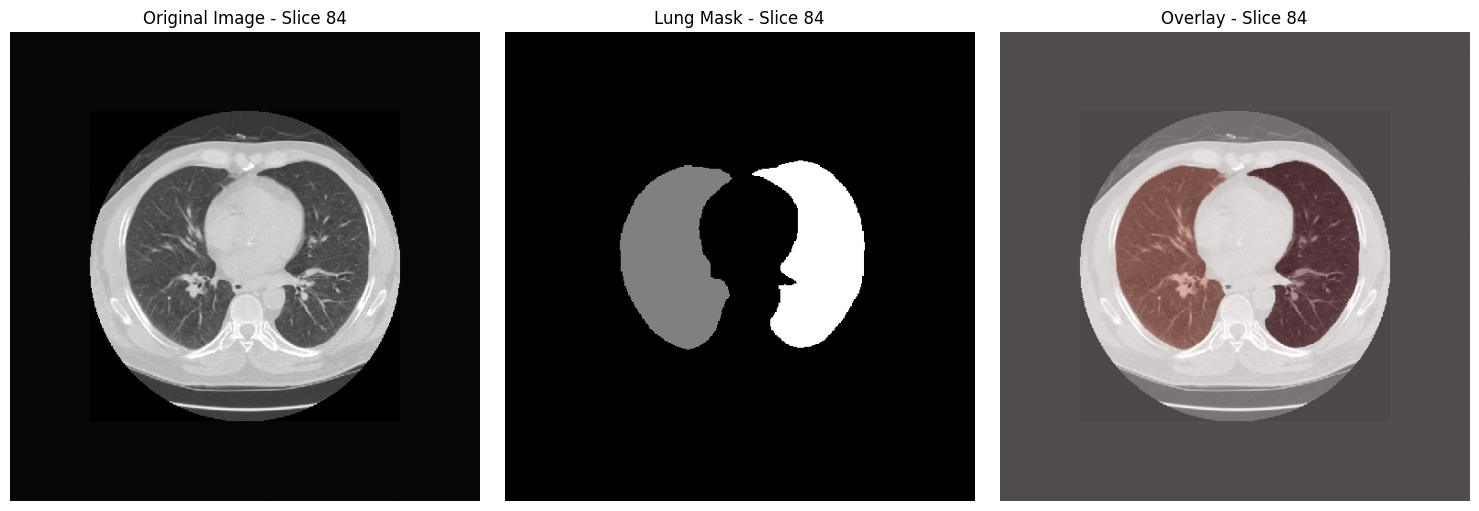

Slice with most non-zero values: 84
Number of non-zero pixels in that slice: 31194


In [8]:
# Run lung mask - transpose to put depth first
# image_ = np.transpose(image, (2, 0, 1))
# note lungmask model expects shape (D, H, W), no batch dimension
lung_mask = model.apply(image)
print(f"Lung mask shape: {lung_mask.shape}")
print(f"Lung mask unique values: {np.unique(lung_mask)}")
# Visualize the slice with most non-zero values
non_zero_counts_per_slice = (lung_mask > 0).sum(axis=(1, 2))
max_nonzero_slice_idx = np.argmax(non_zero_counts_per_slice)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image[max_nonzero_slice_idx, :, :], cmap='gray')
plt.title(f'Original Image - Slice {max_nonzero_slice_idx}')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(lung_mask[max_nonzero_slice_idx], cmap='gray')
plt.title(f'Lung Mask - Slice {max_nonzero_slice_idx}')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image[max_nonzero_slice_idx, :, :], cmap='gray')
plt.imshow(lung_mask[max_nonzero_slice_idx], cmap='Reds', alpha=0.3)
plt.title(f'Overlay - Slice {max_nonzero_slice_idx}')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Slice with most non-zero values: {max_nonzero_slice_idx}")
print(f"Number of non-zero pixels in that slice: {non_zero_counts_per_slice[max_nonzero_slice_idx]}")

# mid_slice = lung_mask.shape[0] // 2

## Preprocess Image

In [9]:
# Apply windowing
# image = apply_windowing(image.astype(np.float64), -600, 1600)
print(f"image type after windowing: {type(image)}, shape: {image.shape}")

# Convert to tensor and normalize
image = torch.tensor(image) // 256
# image = image.permute(2, 0, 1).unsqueeze(0).unsqueeze(0)  # shape: [1, 1, D, H, W]
image = image.unsqueeze(0).unsqueeze(0)  # shape: [1, 1, D, H, W]
print(f"Image shape after unsqueezes: {image.shape}")

# Interpolate to target size
image = F.interpolate(
    image,
    size=(image.shape[2], 1024, 1024),
    mode="trilinear",
    align_corners=False,
)
image = image.squeeze(1)
image = image[None]
print(f"Image shape after interpolation: {image.shape}")

image type after windowing: <class 'numpy.ndarray'>, shape: (208, 512, 512)
Image shape after unsqueezes: torch.Size([1, 1, 208, 512, 512])
Image shape after interpolation: torch.Size([1, 1, 208, 1024, 1024])


In [10]:
# Interpolate lung mask
lung_mask = torch.tensor(lung_mask).unsqueeze(1)
lung_mask = F.interpolate(
    lung_mask,
    size=(1024, 1024),
    mode="nearest-exact",
)
lung_mask = lung_mask.squeeze()
print(f"Lung mask shape after interpolation: {lung_mask.shape}")

Lung mask shape after interpolation: torch.Size([208, 1024, 1024])


## Run Segmentation Model

In [11]:
# Run segmentation
with torch.no_grad():
    segmentation_outputs = segmentation_model.predict(image.float())

print(f"segmentation unique values: {torch.unique(segmentation_outputs)}")

# Create binary segmentation
binary_segmentation = (
    1 * (F.softmax(segmentation_outputs, 1)[0, 1] > 0.5) * lung_mask
)
print(f"Binary segmentation shape: {binary_segmentation.shape}")

segmentation unique values: tensor([-201.7132, -201.0407, -198.1622,  ...,  198.1779,  201.0565,
         201.7292])
Binary segmentation shape: torch.Size([208, 1024, 1024])


## Extract Connected Components

In [12]:
# Get connected components
instance_segmentation, num_instances = cc3d.connected_components(
    binary_segmentation.cpu().numpy(),
    return_N=True,
)
# Get unique values from instance segmentation
unique_vals = np.unique(instance_segmentation)
print(f"Unique instance values: {unique_vals}")
print(f"Number of instances found: {num_instances}")
print(f"Instance segmentation shape: {instance_segmentation.shape}")

# Convert to sparse tensor
sparse_segmentation = torch.tensor(instance_segmentation, dtype=torch.int32).to_sparse()
print(f"Sparse segmentation indices shape: {sparse_segmentation.indices().shape}")

Unique instance values: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104]
Number of instances found: 104
Instance segmentation shape: (208, 1024, 1024)
Sparse segmentation indices shape: torch.Size([3, 8371])


In [13]:
# Reshape image for patch extraction
image = image.squeeze(0).squeeze(0).permute(1, 2, 0)  # shape: H, W, D
print(f"Image shape: {image.shape}")

Image shape: torch.Size([1024, 1024, 208])


## Extract Patches for Each Instance

In [14]:
patches = []
patch_sizes = []  # Track sizes to determine max dimensions
temp_patches = []

# First pass: extract patches and track sizes
for inst_id in range(1, num_instances + 1):
    zs, ys, xs = sparse_segmentation.indices()[
        :, sparse_segmentation.values() == inst_id
    ]
    box = {
        "x_start": torch.min(xs).item(),
        "x_stop": torch.max(xs).item(),
        "y_start": torch.min(ys).item(),
        "y_stop": torch.max(ys).item(),
        "z_start": torch.min(zs).item(),
        "z_stop": torch.max(zs).item(),
    }
    patch = torch.zeros_like(image)
    print(f"patch shape: {patch.shape}")
    patch[
        box["y_start"] : box["y_stop"] + 1,
        box["x_start"] : box["x_stop"] + 1,
        box["z_start"] : box["z_stop"] + 1,
    ] = binary_segmentation[
        box["z_start"] : box["z_stop"] + 1,
        box["y_start"] : box["y_stop"] + 1,
        box["x_start"] : box["x_stop"] + 1,
    ].permute(1, 2, 0)
    cbbox = random_pad_3d_box(
        box,
        image,
        min_height=128,
        min_width=128,
        min_depth=32,  # Increased to 32 to ensure enough depth for network layers
        random_hw=False,
        random_d=False,
    )
    patchx = image[cbbox]
    patchl = patch[cbbox]
    print(f"patchx shape: {patchx.shape}, patchl shape: {patchl.shape}")
    temp_patches.append((patchx, patchl))
    patch_sizes.append(patchx.shape)

print(f"Extracted {len(temp_patches)} patches.")

patch shape: torch.Size([1024, 1024, 208])
patchx shape: torch.Size([128, 128, 32]), patchl shape: torch.Size([128, 128, 32])
patch shape: torch.Size([1024, 1024, 208])
patchx shape: torch.Size([128, 128, 32]), patchl shape: torch.Size([128, 128, 32])
patch shape: torch.Size([1024, 1024, 208])
patchx shape: torch.Size([128, 128, 32]), patchl shape: torch.Size([128, 128, 32])
patch shape: torch.Size([1024, 1024, 208])
patchx shape: torch.Size([128, 128, 32]), patchl shape: torch.Size([128, 128, 32])
patch shape: torch.Size([1024, 1024, 208])
patchx shape: torch.Size([128, 128, 32]), patchl shape: torch.Size([128, 128, 32])
patch shape: torch.Size([1024, 1024, 208])
patchx shape: torch.Size([128, 128, 32]), patchl shape: torch.Size([128, 128, 32])
patch shape: torch.Size([1024, 1024, 208])
patchx shape: torch.Size([128, 128, 32]), patchl shape: torch.Size([128, 128, 32])
patch shape: torch.Size([1024, 1024, 208])
patchx shape: torch.Size([128, 128, 32]), patchl shape: torch.Size([128, 12

In [15]:
# Determine maximum dimensions across all patches
# Also save images of slices with most non-zero values
# Also get the number of pixels greater than zero in each patch
output_path = Path("saved_images/cancer_patch_slices/")
output_path.mkdir(exist_ok=True)
pixelCounts = {}

for inst_id, (patchx, patchl) in enumerate(temp_patches, start=1):
    # Find slice with most non-zero values
    non_zero_counts = (patchl > 0).sum(dim=(0, 1))  # Sum over H and W dimensions
    num_pixels_greater_than_zero = non_zero_counts.sum().item()
    pixelCounts[inst_id] = num_pixels_greater_than_zero
    max_slice_idx = torch.argmax(non_zero_counts).item()
    
    # Extract the slice
    img_slice = patchx[:, :, max_slice_idx].numpy()
    mask_slice = patchl[:, :, max_slice_idx].numpy()
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(img_slice, cmap='gray')
    axes[0].set_title(f'Instance {inst_id} - Image (Slice {max_slice_idx})')
    axes[0].axis('off')
    
    # Mask
    axes[1].imshow(mask_slice, cmap='gray')
    axes[1].set_title(f'Instance {inst_id} - Mask (Slice {max_slice_idx})')
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(img_slice, cmap='gray')
    axes[2].imshow(mask_slice, cmap='Reds', alpha=0.5)
    axes[2].set_title(f'Instance {inst_id} - Overlay (Slice {max_slice_idx})')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(output_path / f'instance_{inst_id:03d}_slice_{max_slice_idx}.png', dpi=100, bbox_inches='tight')
    plt.close()

print(f"Saved visualizations to {output_path}")
print(f"Pixel counts greater than zero per instance: {pixelCounts}")

Saved visualizations to saved_images/cancer_patch_slices
Pixel counts greater than zero per instance: {1: 2, 2: 2, 3: 1, 4: 39, 5: 1, 6: 533, 7: 1, 8: 17, 9: 1, 10: 1, 11: 3, 12: 2, 13: 10, 14: 1, 15: 1, 16: 8, 17: 4, 18: 3, 19: 101, 20: 1, 21: 179, 22: 35, 23: 578, 24: 6, 25: 4, 26: 1, 27: 36, 28: 1, 29: 1, 30: 249, 31: 3, 32: 9, 33: 2, 34: 6, 35: 193, 36: 177, 37: 12, 38: 7, 39: 4, 40: 155, 41: 1, 42: 3, 43: 2, 44: 2, 45: 1, 46: 1, 47: 118, 48: 148, 49: 4, 50: 4, 51: 57, 52: 19, 53: 273, 54: 1, 55: 84, 56: 2, 57: 13, 58: 2, 59: 5, 60: 2, 61: 15, 62: 783, 63: 54, 64: 1, 65: 4, 66: 1, 67: 4, 68: 3, 69: 5, 70: 104, 71: 13, 72: 7, 73: 6, 74: 13, 75: 347, 76: 156, 77: 21, 78: 74, 79: 76, 80: 95, 81: 1390, 82: 110, 83: 1, 84: 1, 85: 9, 86: 152, 87: 204, 88: 26, 89: 92, 90: 1009, 91: 132, 92: 4, 93: 11, 94: 17, 95: 3, 96: 1, 97: 1, 98: 1, 99: 3, 100: 2, 101: 1, 102: 176, 103: 58, 104: 72}


In [16]:
pixel_spacing = [0.703125, 0.703125, 2.5]
pixel_volume = pixel_spacing[0] * pixel_spacing[1] * pixel_spacing[2]
patch_volumes = {inst_id: count * pixel_volume for inst_id, count in pixelCounts.items()}
print(f"Patch volumes (in mm^3) per instance: {patch_volumes}")

Patch volumes (in mm^3) per instance: {1: 2.471923828125, 2: 2.471923828125, 3: 1.2359619140625, 4: 48.2025146484375, 5: 1.2359619140625, 6: 658.7677001953125, 7: 1.2359619140625, 8: 21.0113525390625, 9: 1.2359619140625, 10: 1.2359619140625, 11: 3.7078857421875, 12: 2.471923828125, 13: 12.359619140625, 14: 1.2359619140625, 15: 1.2359619140625, 16: 9.8876953125, 17: 4.94384765625, 18: 3.7078857421875, 19: 124.8321533203125, 20: 1.2359619140625, 21: 221.2371826171875, 22: 43.2586669921875, 23: 714.385986328125, 24: 7.415771484375, 25: 4.94384765625, 26: 1.2359619140625, 27: 44.49462890625, 28: 1.2359619140625, 29: 1.2359619140625, 30: 307.7545166015625, 31: 3.7078857421875, 32: 11.1236572265625, 33: 2.471923828125, 34: 7.415771484375, 35: 238.5406494140625, 36: 218.7652587890625, 37: 14.83154296875, 38: 8.6517333984375, 39: 4.94384765625, 40: 191.5740966796875, 41: 1.2359619140625, 42: 3.7078857421875, 43: 2.471923828125, 44: 2.471923828125, 45: 1.2359619140625, 46: 1.2359619140625, 47: 

## Pad Patches to Uniform Size

In [17]:
# Determine maximum dimensions across all patches
max_h = max(s[0] for s in patch_sizes)
max_w = max(s[1] for s in patch_sizes)
# max_d = max(s[2] for s in patch_sizes)
max_d = 32
print(f"Max patch dimensions: H={max_h}, W={max_w}, D={max_d}")

# Second pass: pad all patches to max dimensions
for patchx, patchl in temp_patches:
    # Pad to max dimensions
    pad_h = max_h - patchx.shape[0]
    pad_w = max_w - patchx.shape[1]
    pad_d = max_d - patchx.shape[2]
    
    if pad_h > 0 or pad_w > 0 or pad_d > 0:
        patchx = F.pad(patchx, (0, pad_d, 0, pad_w, 0, pad_h), mode='constant', value=0)
        patchl = F.pad(patchl, (0, pad_d, 0, pad_w, 0, pad_h), mode='constant', value=0)
    
    patch = torch.stack([patchx, patchl])
    print(f"Padded patch shape: {patch.shape}")
    patches.append(patch)

patches = torch.stack(patches)
print(f"Total patches shape: {patches.shape}")

Max patch dimensions: H=128, W=128, D=32
Padded patch shape: torch.Size([2, 128, 128, 32])
Padded patch shape: torch.Size([2, 128, 128, 32])
Padded patch shape: torch.Size([2, 128, 128, 32])
Padded patch shape: torch.Size([2, 128, 128, 32])
Padded patch shape: torch.Size([2, 128, 128, 32])
Padded patch shape: torch.Size([2, 128, 128, 32])
Padded patch shape: torch.Size([2, 128, 128, 32])
Padded patch shape: torch.Size([2, 128, 128, 32])
Padded patch shape: torch.Size([2, 128, 128, 32])
Padded patch shape: torch.Size([2, 128, 128, 32])
Padded patch shape: torch.Size([2, 128, 128, 32])
Padded patch shape: torch.Size([2, 128, 128, 32])
Padded patch shape: torch.Size([2, 128, 128, 32])
Padded patch shape: torch.Size([2, 128, 128, 32])
Padded patch shape: torch.Size([2, 128, 128, 32])
Padded patch shape: torch.Size([2, 128, 128, 32])
Padded patch shape: torch.Size([2, 128, 128, 32])
Padded patch shape: torch.Size([2, 128, 128, 32])
Padded patch shape: torch.Size([2, 128, 128, 32])
Padded pa

## Run Confidence Model

In [18]:
# Run confidence model
with torch.no_grad():
    confidence_outputs = confidence_model(patches.float())

# print(f"Confidence outputs shape: {torch.as_tensor(confidence_outputs).shape}")
# print(f"Confidence outputs: {confidence_outputs}")

logits = confidence_outputs['logit']
print(f"Logits shape: {logits.shape}")
# run softmax on logits to get confidence scores
confidence_scores = F.softmax(logits, dim=1)
print(f"confidence scores: {confidence_scores}")

Logits shape: torch.Size([104, 2])
confidence scores: tensor([[0.9278, 0.0722],
        [0.9293, 0.0707],
        [0.8075, 0.1925],
        [0.7925, 0.2075],
        [0.5942, 0.4058],
        [0.0763, 0.9237],
        [0.8592, 0.1408],
        [0.8487, 0.1513],
        [0.8717, 0.1283],
        [0.8953, 0.1047],
        [0.9213, 0.0787],
        [0.6003, 0.3997],
        [0.7726, 0.2274],
        [0.6219, 0.3781],
        [0.6908, 0.3092],
        [0.7409, 0.2591],
        [0.8611, 0.1389],
        [0.8401, 0.1599],
        [0.6825, 0.3175],
        [0.7668, 0.2332],
        [0.7016, 0.2984],
        [0.6923, 0.3077],
        [0.5741, 0.4259],
        [0.5264, 0.4736],
        [0.7796, 0.2204],
        [0.4655, 0.5345],
        [0.7750, 0.2250],
        [0.7847, 0.2153],
        [0.7158, 0.2842],
        [0.6487, 0.3513],
        [0.5964, 0.4036],
        [0.3296, 0.6704],
        [0.5553, 0.4447],
        [0.8489, 0.1511],
        [0.7931, 0.2069],
        [0.7927, 0.2073],
        [0